<a href="https://colab.research.google.com/github/Aminfaraji/segmentaion_document_Unet/blob/main/document%20segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import nibabel
import matplotlib.pyplot as plt
from skimage.util import montage
import os,cv2
from google.colab.patches import cv2_imshow
from skimage import io
from keras.preprocessing.image import load_img,img_to_array
import keras as K
import tensorflow as tf
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar
!unrar x /content/dataset_segmentation.rar

--2021-01-30 22:04:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410202288 (391M) [application/x-httpd-php]
Saving to: ‘dataset_segmentation.rar’

dataset_segmentatio 100%[===================>] 391.20M  19.4MB/s    in 21s     

2021-01-30 22:05:13 (18.2 MB/s) - ‘dataset_segmentation.rar’ saved [410202288/410202288]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset_segmentation.rar

Creating    dataset_segmentation                                      OK
Extracting  dataset_segmentation/1.jpg                                     0%  OK 
Extracting  dataset_segmentation/10.jpg                                    0%  OK 
Extracting  dataset_segmentation/10_m.png

In [10]:
images=glob.glob("/content/dataset_segmentation/*.jpg")
mask=glob.glob("/content/dataset_segmentation/*.png")
train_image=[]
train_mask=[]
for i in range(len(images)):
  img=load_img(images[i],target_size=(256,256))
  mask_=load_img(images[i][:-4]+"_m.png",target_size=(256,256))
  img=img_to_array(img)
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  train_image.append(img)
  mask_=img_to_array(mask_)
  # mask_=np.where(np.where(mask_==255,0,255)==0,255,0)
  mask_=(mask_-np.min(mask_))/(np.max(mask_)-np.min(mask_))
  train_mask.append(mask_)
  print(images[i],"+++++",images[i][:-4]+"_m.png")
# def generate(images,mask,batch_size=16):
#   train_image_gen=ImageDataGenerator().flow(np.reshape(train_image,(75,256,256,3)),y=None,batch_size=batch_size,seed=32)
#   train_mask_gen=ImageDataGenerator().flow(np.reshape(train_mask,(75,256,256,3)),y=None,batch_size=batch_size,seed=32)
#   while True:
#     image=train_image_gen.next()
#     masks=train_mask_gen.next()
#     yield image,masks
train_image=np.array(train_image)
train_mask=np.array(train_mask)

In [4]:
input_=K.Input((256,256,3))
conv1=K.layers.Conv2D(32,3,activation='relu',padding='same')(input_)
# conv1=K.layers.BatchNormalization(momentum=.8)(conv1)
conv1=K.layers.Conv2D(32,3,activation='relu',padding='same')(conv1)
# conv1=K.layers.Dropout(.25)(conv1)
pool1=K.layers.MaxPool2D()(conv1)

conv2=K.layers.Conv2D(64,3,activation='relu',padding='same')(pool1)
# conv2=K.layers.BatchNormalization(momentum=.8)(conv2)
conv2=K.layers.Conv2D(64,3,activation='relu',padding='same')(conv2)
# conv2=K.layers.Dropout(.25)(conv2)
pool2=K.layers.MaxPool2D()(conv2)

conv3=K.layers.Conv2D(128,3,activation='relu',padding='same')(pool2)
conv3=K.layers.Conv2D(128,3,activation='relu',padding='same')(conv3)
# conv3=K.layers.Dropout(.25)(conv3)
pool3=K.layers.MaxPool2D()(conv3)

conv4=K.layers.Conv2D(256,3,activation='relu',padding='same')(pool3)
# conv4=K.layers.BatchNormalization(momentum=.8)(conv4)
conv4=K.layers.Conv2D(256,3,activation='relu',padding='same')(conv4)
pool4=K.layers.MaxPool2D()(conv4)

conv5=K.layers.Conv2D(512,3,activation='relu',padding='same')(pool4)
conv5=K.layers.Conv2D(512,3,activation='relu',padding='same')(conv5)
conv5=K.layers.Dropout(.25)(conv5)
pool5=K.layers.MaxPool2D()(conv5)

u6=K.layers.concatenate([K.layers.Conv2DTranspose(256,(2,2),(2,2),padding="same")(conv5),conv4],axis=3)
conv6=K.layers.Conv2D(256,3,activation="relu",padding="same")(u6)
conv6=K.layers.Conv2D(256,3,activation="relu",padding="same")(conv6)

u7=K.layers.concatenate([K.layers.Conv2DTranspose(128,2,(2,2),padding="same")(conv6),conv3],axis=3)
conv7=K.layers.Conv2D(128,3,activation="relu",padding="same")(u7)
# conv7=K.layers.BatchNormalization(momentum=.8)(conv7)
conv7=K.layers.Conv2D(128,3,activation="relu",padding="same")(conv7)

u8=K.layers.concatenate([K.layers.Conv2DTranspose(64,2,(2,2),padding="same")(conv7),conv2],axis=3)
conv8=K.layers.Conv2D(64,3,activation="relu",padding="same")(u8)
# conv8=K.layers.Dropout(.25)(conv8)
conv8=K.layers.Conv2D(64,3,activation="relu",padding="same")(conv8)


u9=K.layers.concatenate([K.layers.Conv2DTranspose(32,2,(2,2),padding="same")(conv8),conv1],axis=3)
conv9=K.layers.Conv2D(32,3,activation="relu",padding="same")(u9)
# conv9=K.layers.BatchNormalization(momentum=.8)(conv9)
# conv9=K.layers.Dropout(.25)(conv9)
conv9=K.layers.Conv2D(32,3,activation="relu",padding="same")(conv9)

conv10=K.layers.Conv2D(3,1,activation="sigmoid")(conv9)

model=K.Model([input_],[conv10])

In [8]:
# image_batch, mask_batch = next(generate(images,train_image,batch_size=16))
# fix, ax = plt.subplots(8,2, figsize=(8,20))
# for i in range(8):
#     ax[i,0].imshow(image_batch[i,:,:,:])
#     ax[i,1].imshow(mask_batch[i,:,:,:])
# plt.show()

In [14]:
def dice_coff(y_true,y_pred):
  y_true=K.backend.flatten(y_true)
  y_pred=K.backend.flatten(y_pred)
  intersecion=K.backend.sum(y_true*y_pred)
  return (2*intersecion+1e-07)/(K.backend.sum(y_true)+K.backend.sum(y_pred)+1e-07)

model.compile(K.optimizers.Adam(2e-5),loss=K.losses.binary_crossentropy,metrics=dice_coff)

In [15]:
model.fit(train_image,train_mask,batch_size=16,epochs=200)
# model.fit_generator(generate(train_image,train_mask,batch_size=8),epochs=50,steps_per_epoch=50)

Epoch 1/200
5/5 [==============================] - 3s 394ms/step - loss: 0.6984 - dice_coff: 0.5081
Epoch 2/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6954 - dice_coff: 0.5109
Epoch 3/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6925 - dice_coff: 0.5139
Epoch 4/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6897 - dice_coff: 0.5091
Epoch 5/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6869 - dice_coff: 0.5114
Epoch 6/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6831 - dice_coff: 0.5208
Epoch 7/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6806 - dice_coff: 0.5200
Epoch 8/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6774 - dice_coff: 0.5189
Epoch 9/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6747 - dice_coff: 0.5246
Epoch 10/200
5/5 [==============================] - 1s 132ms/step - loss: 0.6704 - dice_coff: 0.5306

(<matplotlib.image.AxesImage at 0x7f6f685e89e8>,
 <matplotlib.image.AxesImage at 0x7f6f685ac4a8>)

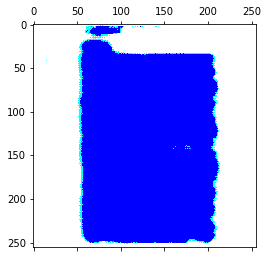

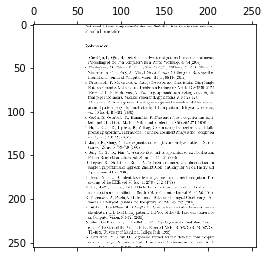

In [16]:
img=img_to_array(load_img("/content/Screenshot from 2020-12-30 22-58-49.png",target_size=(256,256)))
img_pred=model.predict(img.reshape((1,256,256,3)))
plt.matshow(img_pred[0]),plt.matshow(img/255)

(<matplotlib.image.AxesImage at 0x7f6f68034588>,
 <matplotlib.image.AxesImage at 0x7f6f627c0048>)

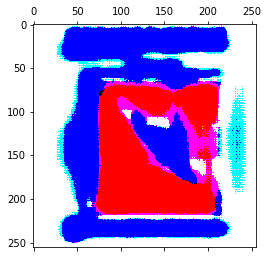

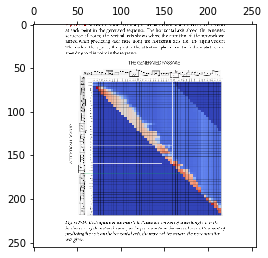

In [17]:
img=img_to_array(load_img("/content/Screenshot from 2020-12-30 18-56-48.png",target_size=(256,256)))
img_pred=model.predict(img.reshape((1,256,256,3)))
plt.matshow(img_pred[0]),plt.matshow(img/255)

(<matplotlib.image.AxesImage at 0x7f6f627bc828>,
 <matplotlib.image.AxesImage at 0x7f6f627772e8>)

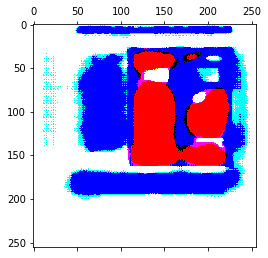

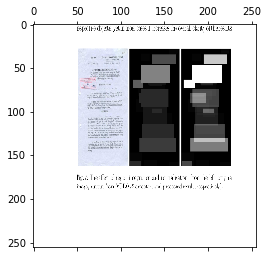

In [18]:
img=img_to_array(load_img("/content/Screenshot from 2020-12-30 22-58-28.png",target_size=(256,256)))
img_pred=model.predict(img.reshape((1,256,256,3)))
plt.matshow(img_pred[0]),plt.matshow(img/255)